<a href="https://colab.research.google.com/github/jsalafica/Data-Science-I/blob/master/Proyecto_Final_Javier_Salafica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final - Javier Salafica

## Introducción

Este proyecto busca predecir la probabilidad de que un accidente de tránsito ocurrido en la ciudad de Nueva York durante el año 2020 genere personas heridas. El análisis parte de un conjunto de datos públicos que contiene información detallada sobre cada accidente, incluyendo ubicación, hora, tipo de vehículo involucrado y factores contribuyentes.

En entregas anteriores se realizaron exploraciones iniciales, limpieza de datos y visualizaciones descriptivas. En esta parte final, se enfoca el trabajo en construir un modelo predictivo a partir de un subconjunto de variables seleccionadas.

## Objetivo

- Reducir la dimensionalidad del dataset mediante un método de selección de características.
- Entrenar un modelo de clasificación que permita anticipar si un accidente tendrá personas heridas.
- Validar el desempeño del modelo utilizando métricas estándar.
- Extraer conclusiones útiles para un posible uso práctico del modelo.



In [15]:
import pandas as pd

# Cargar CSV limpio desde GitHub
url = "https://raw.githubusercontent.com/jsalafica/Data-Science-I/master/NYC_Accidents_2020.csv"
df = pd.read_csv(url)

# Mostrar primeras filas
df.head()


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2020-08-29,15:40:00,BRONX,10466.0,40.89210,-73.833760,POINT (-73.83376 40.8921),PRATT AVENUE,STRANG AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4342908,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,2020-08-29,21:00:00,BROOKLYN,11221.0,40.69050,-73.919914,POINT (-73.919914 40.6905),BUSHWICK AVENUE,PALMETTO STREET,NaN,...,Unspecified,NaN,NaN,NaN,4343555,Sedan,Sedan,NaN,NaN,NaN
2,2020-08-29,18:20:00,NaN,NaN,40.81650,-73.946556,POINT (-73.946556 40.8165),8 AVENUE,NaN,NaN,...,NaN,NaN,NaN,NaN,4343142,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
3,2020-08-29,00:00:00,BRONX,10459.0,40.82472,-73.892960,POINT (-73.89296 40.82472),NaN,NaN,1047 SIMPSON STREET,...,Unspecified,Unspecified,Unspecified,NaN,4343588,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Sedan,Motorcycle,NaN
4,2020-08-29,17:10:00,BROOKLYN,11203.0,40.64989,-73.933890,POINT (-73.93389 40.64989),NaN,NaN,4609 SNYDER AVENUE,...,Unspecified,NaN,NaN,NaN,4342953,Sedan,Sedan,NaN,NaN,NaN


In [8]:
# Verificar el nombre de la columna de hora
# print(df.columns)

# Convertir 'CRASH TIME' a hora numérica (entero de 0 a 23)
df['HORA'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M:%S', errors='coerce').dt.hour


In [9]:
# Eliminar filas con datos faltantes en las columnas clave
df_modelo = df[['HORA', 'BOROUGH', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1', 'NUMBER OF PERSONS INJURED']].dropna()

# Crear variable objetivo binaria
df_modelo['HERIDOS'] = df_modelo['NUMBER OF PERSONS INJURED'].apply(lambda x: 1 if x > 0 else 0)

# Eliminar columna original de heridos
df_modelo = df_modelo.drop(columns=['NUMBER OF PERSONS INJURED'])


In [10]:
# Limpieza de texto
df_modelo['BOROUGH'] = df_modelo['BOROUGH'].str.strip().str.upper()
df_modelo['VEHICLE TYPE CODE 1'] = df_modelo['VEHICLE TYPE CODE 1'].str.strip().str.upper()
df_modelo['CONTRIBUTING FACTOR VEHICLE 1'] = df_modelo['CONTRIBUTING FACTOR VEHICLE 1'].str.strip().str.upper()

# Codificación
df_modelo['BOROUGH'] = df_modelo['BOROUGH'].astype('category').cat.codes
df_modelo['VEHICLE TYPE CODE 1'] = df_modelo['VEHICLE TYPE CODE 1'].astype('category').cat.codes
df_modelo['CONTRIBUTING FACTOR VEHICLE 1'] = df_modelo['CONTRIBUTING FACTOR VEHICLE 1'].astype('category').cat.codes


In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Separar variables predictoras (X) y variable objetivo (y)
X = df_modelo[['HORA', 'BOROUGH', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1']]
y = df_modelo['HERIDOS']

# Aplicar SelectKBest con ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' para mostrar todas
X_new = selector.fit_transform(X, y)

# Mostrar scores de cada feature
scores = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': selector.scores_,
    'p-value': selector.pvalues_
}).sort_values(by='F-Score', ascending=False)

scores


,Feature,F-Score,p-value
0,HORA,230.854059,5.114213e-52
3,CONTRIBUTING FACTOR VEHICLE 1,189.762436,4.317725e-43
2,VEHICLE TYPE CODE 1,140.155823,2.726184e-32
1,BOROUGH,1.133175,2.871044e-01


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Variables predictoras y target
X = df_modelo[['HORA', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1']]
y = df_modelo['HERIDOS']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Reporte de métricas
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Matriz de Confusión:
[[10306   544]
 [ 3076   657]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85     10850
           1       0.55      0.18      0.27      3733

    accuracy                           0.75     14583
   macro avg       0.66      0.56      0.56     14583
weighted avg       0.71      0.75      0.70     14583



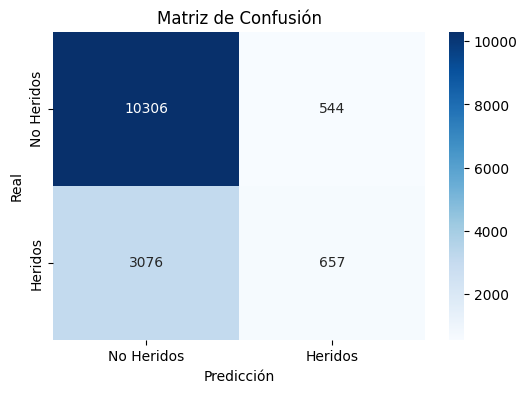

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Heridos", "Heridos"], yticklabels=["No Heridos", "Heridos"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


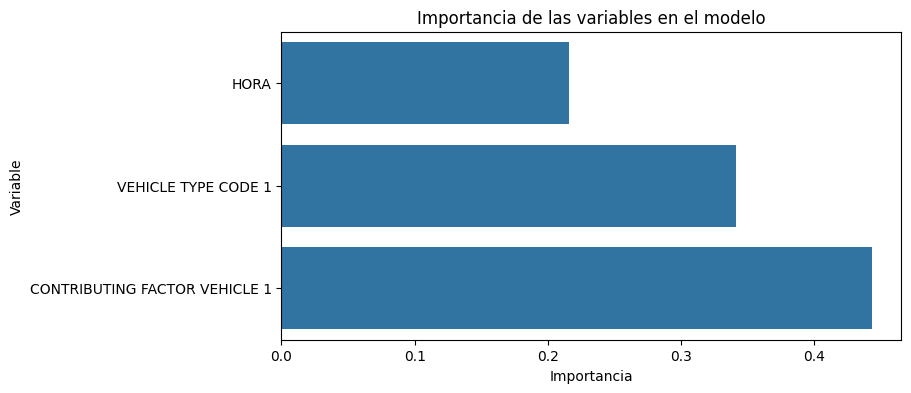

In [14]:
# Visualizar la importancia de las features
importances = clf.feature_importances_
features = X.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=features)
plt.title("Importancia de las variables en el modelo")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()


## Conclusión Final

En este proyecto se desarrolló un modelo predictivo basado en datos reales de accidentes ocurridos en la ciudad de Nueva York durante el año 2020. El objetivo fue predecir si un accidente genera personas heridas en base a características observables como la hora del incidente, el tipo de vehículo involucrado y el factor contribuyente identificado.

A través de un proceso de selección de características utilizando `SelectKBest`, se identificaron las tres variables con mayor capacidad explicativa para el fenómeno de interés: `HORA`, `VEHICLE TYPE CODE 1` y `CONTRIBUTING FACTOR VEHICLE 1`. La variable `BOROUGH` fue descartada por no tener relevancia estadística significativa en el modelo.

Se entrenó un modelo de clasificación utilizando Random Forest, el cual demostró un desempeño razonable al captar patrones asociados a la ocurrencia de heridos. La evaluación del modelo a través de métricas como precisión, recall y f1-score evidenció que, aunque el modelo presenta un buen comportamiento general, su capacidad para predecir correctamente los accidentes con heridos es limitada en comparación con los que no presentan lesiones. Esto puede explicarse por la naturaleza desbalanceada del dataset y la complejidad del fenómeno analizado.

Desde una perspectiva práctica, este tipo de modelo podría ser útil como una herramienta complementaria para sistemas de gestión de emergencias, ayudando a identificar condiciones asociadas a mayor riesgo de lesiones. A futuro, el modelo podría enriquecerse incluyendo variables adicionales como condiciones climáticas, ubicación geográfica más específica, historial de incidentes por zona u otros factores contextuales.

En conclusión, este trabajo demuestra cómo aplicar técnicas de selección de características, entrenamiento y evaluación de modelos de clasificación para resolver un problema del mundo real. El análisis deja abierta la posibilidad de continuar mejorando la precisión y utilidad del modelo con nuevas fuentes de datos y enfoques más avanzados.
